In [0]:
import glob
import sys
import numpy as np
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.linear_model import LogisticRegression as LR
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import *
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd

In [6]:
# pd.read_csv('https://storage.cloud.google.com/kkbox-churn/PTSD_data_annotated.csv', encoding = 'ISO-8859-1')
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [8]:
path = ''
data_file = '/content/drive/My Drive/Colab Notebooks/PTSD_data_annotated.csv'

data_df = pd.read_csv(data_file, encoding = 'ISO-8859-1')
#This code assumes the data file has a header at the top, and the rows are all annotated. 
# I removed the blank labeled rows from the bottom.


data_df = data_df.iloc[:517]
print(data_df.count())
# filter on CLIENT character
data_df = data_df[data_df['character'] == 'CLIENT']

print(data_df.isnull().sum().sum())
data_df = data_df.fillna(0)
data_df = data_df.replace('NaN', 0)

print(data_df.isnull().sum().sum()) 


    
# comment out the actual text before pushing to github
print(data_df.transcript_id.value_counts())
print(data_df.head(3))
print(data_df.columns)
print(data_df.describe())



transcript_id                       517
character                           517
text                                517
Keywords / Significant sentences     34
A1                                  517
B1                                  517
B2                                  517
B3                                  517
B4                                  517
B5                                  517
C1                                  517
C2                                  517
D1                                  517
D2                                  517
D3                                  517
D4                                  517
D5                                  517
D6                                  517
D7                                  517
E1                                  517
E2                                  517
E3                                  517
E4                                  517
E5                                  517
E6                                  517


In [9]:
dataframe_targets = data_df.groupby("transcript_id").sum()[["A1","B1","B2","B3","B4","B5","C1","C2","D1","D2","D3","D4","D5","D6","D7","E1","E2","E3","E4","E5","E6","F1","G1"]]
data_frame_text_fields =  data_df.groupby("transcript_id")["text"].agg(lambda col: ''.join(col))

data_frame_text_fields = data_frame_text_fields.to_frame()
data_frame_text_fields.reset_index(level=0, inplace=True)
dataframe_targets.reset_index(level=0, inplace=True)

# any class with a value of 1 or more, will count as labeled
dataframe_targets.iloc[:,1:] = np.where(dataframe_targets.iloc[:,1:]>=1.0, 1, 0)

dataframe_targets.head()


,transcript_id,A1,B1,B2,B3,B4,B5,C1,C2,D1,D2,D3,D4,D5,D6,D7,E1,E2,E3,E4,E5,E6,F1,G1
0,PTSD_file_1,1,0,0,0,0,0,1,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0
1,PTSD_file_2,1,0,0,0,1,1,1,1,0,1,1,1,0,0,0,1,0,1,0,0,0,0,0
2,PTSD_file_3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
data_frame_merged = pd.merge(dataframe_targets, data_frame_text_fields, on="transcript_id")

# data_frame_merged.head(10)

['A1', 'B1', 'B2', 'B3', 'B4', 'B5', 'C1', 'C2', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'E1', 'E2', 'E3', 'E4', 'E5', 'E6', 'F1', 'G1']


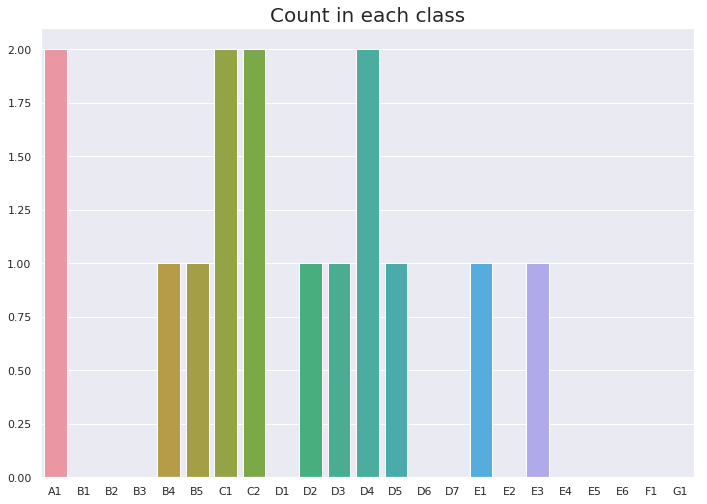

In [11]:
import seaborn as sns
import matplotlib as plt

categories = list(data_frame_merged.columns.values)
print(categories[1:-1])
sns.set(font_scale = 2)
sns.set(rc={'figure.figsize':(11.7,8.27)})

sns.barplot(categories[1:-1], data_frame_merged.iloc[:,1:-1].sum().values).set_title('Count in each class', fontsize=20)
# plt.title("Comments in each category", fontsize=24)
# plt.ylabel('Number of comments', fontsize=18)
# plt.xlabel('Comment Type ', fontsize=18)
#adding the text labels
#rects = ax.patches
labels = data_frame_merged.iloc[:,1:-1].sum().values
# for rect, label in zip(rects, labels):
#     height = rect.get_height()
#     ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom', fontsize=18)


0     5
1    10
2     0
dtype: int64
10    1
5     1
0     1
dtype: int64


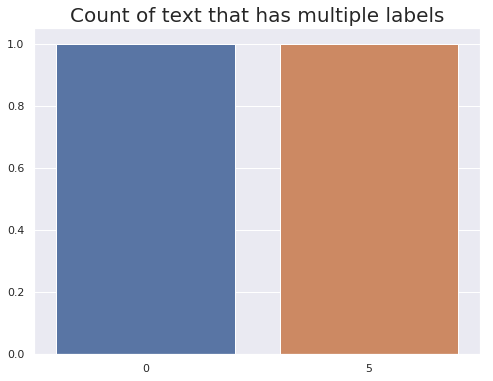

In [12]:

rowSums = data_frame_merged.iloc[:,1:-1].sum(axis=1)
print(rowSums)
multiLabel_counts = rowSums.value_counts()
print(multiLabel_counts)
multiLabel_counts = multiLabel_counts.iloc[1:]
sns.set(font_scale = 2)
sns.set(rc={'figure.figsize':(8,6)})
sns.barplot(multiLabel_counts.index, multiLabel_counts.values).set_title('Count of text that has multiple labels', fontsize=20)
# plt.title("Comments having multiple labels ")
# plt.ylabel('Number of comments', fontsize=18)
# plt.xlabel('Number of labels', fontsize=18)
#adding the text labels
ax = sns.barplot(multiLabel_counts.index, multiLabel_counts.values)
rects = ax.patches
labels = multiLabel_counts.values
# print(rowSums.value_counts())
# print(labels)
# for rect, label in zip(rects, labels):
#     height = rect.get_height()
#     ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')


In [13]:
# continue with guidance from: https://towardsdatascience.com/journey-to-the-center-of-multi-label-classification-384c40229bff

import re
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
#is based on The Porter Stemming Algorithm
wnl = nltk.stem.WordNetLemmatizer()
stopword = stopwords.words('english')
snowball_stemmer = SnowballStemmer('english')

def clean(sentence): #function to tokenize, lemmatize, remove non-alpha characters, numbers in time stamps (00), stem, remove stop words
# trying a Bag of words feature vector
    sentence = re.sub('[^A-Za-z!0-9]+', ' ', sentence)
    sentence = re.sub(r'\d{2}','',sentence) 
    sentence = sentence.strip()
    sentence = [wnl.lemmatize(i) for i in word_tokenize(sentence)]
    sentence = [snowball_stemmer.stem(word) for word in sentence]
    sentence = [word for word in sentence if word not in stopword]
#other potential tasks:
# 1) convert contractions
# 2) mispellings
    return sentence

    
    
    

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [0]:


# changing to use the pandas df
def load_df(df): #loads the text, cleans it, stores it into a list of lists, and calculates word frequency

    for transcript in df.text.iteritems():
        tokens = clean(transcript[1])
        for word in tokens:
            if word in word_count:
                word_count[word] += 1
            else:
                word_count[word] = 1
        text_list.append(tokens)
 

In [15]:
print(data_frame_merged.isnull().sum().sum()) 
print(len(data_frame_merged))

0
3


In [16]:
word_count = {}    
text_list = []
load_df(data_frame_merged)     
print(len(word_count))
print(len(text_list))
# for w in sorted(word_count, key=word_count.get, reverse=True):
#     print (w, word_count[w])

# concat the text list to the the categories, or to the dataframe

text_list_series = pd.Series(text_list)

#reset the index of both before the concat to ensure they line up
text_list_series.reset_index(drop=True, inplace=True)
data_frame_merged.reset_index(drop=True, inplace=True)

df_w_tokens = pd.concat([data_frame_merged, text_list_series],axis=1)
print(df_w_tokens.isnull().sum().sum()) 
print(df_w_tokens.head(3))
print(df_w_tokens.count())
print(df_w_tokens.columns)
# I am renaming all columns, but really just needed to name the column for the concatted series

df_w_tokens.columns = ['transcript_id','A1', 'B1', 'B2', 'B3', 'B4', 'B5', 'C1', 'C2', 'D1', 'D2', 'D3', 'D4', 
                       'D5', 'D6', 'D7', 'E1', 'E2', 'E3', 'E4', 'E5', 'E6', 'F1', 'G1','text','tokens']


 
# df_w_tokens.columns = ['transcript_id','character','text', 'Keywords / Significant sentences', 'A1', 'B1', 'B2', 'B3', 'B4', 'B5', 'C1', 'C2',
# 'D1',                               'D2',
#                                      'D3',                               'D4',
#                                      'D5',                               'D6',
#                                      'D7',                               'E1',
#                                      'E2',                               'E3',
#                                      'E4',                               'E5',
#                                      'E6',                               'F1',
#                                      'G1',                                  'tokens']



print(df_w_tokens.isnull().sum().sum())
# df_w_tokens = data_frame_merged.replace('NaN', '')
# df_w_tokens = data_frame_merged.fillna(0)
# print(df_w_tokens.isnull().sum().sum())
# print(list(df_w_tokens.columns))
print(df_w_tokens.head(3))


1060
3
0
  transcript_id  ...                                                  0
0   PTSD_file_1  ...  [remind, never, go, work, meet, bunch, woman, ...
1   PTSD_file_2  ...  [okay, schedul, appoint, dr, vaughn, monday, a...
2   PTSD_file_3  ...  [oh, thank, aw, fuck, sorri, right, come, back...

[3 rows x 26 columns]
transcript_id    3
A1               3
B1               3
B2               3
B3               3
B4               3
B5               3
C1               3
C2               3
D1               3
D2               3
D3               3
D4               3
D5               3
D6               3
D7               3
E1               3
E2               3
E3               3
E4               3
E5               3
E6               3
F1               3
G1               3
text             3
0                3
dtype: int64
Index(['transcript_id',            'A1',            'B1',            'B2',
                  'B3',            'B4',            'B5',            'C1',
                  'C2',

In [17]:
# Bag of Words 

from sklearn.model_selection import train_test_split
train, test = train_test_split(df_w_tokens, random_state=42, test_size=0.30, shuffle=True)

# consider a stratified test/train split, and/or temporal

def dummy_fun(doc):
    return doc

from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(
    analyzer='word', 
    ngram_range=(1,3), 
    norm='l2',     
    tokenizer=dummy_fun,
    preprocessor=dummy_fun,
    token_pattern=None)

vectorizer.fit(train['tokens'])
vectorizer.fit(test['tokens'])

x_train = vectorizer.transform(train['tokens'])

x_test = vectorizer.transform(test['tokens'])

print(categories[1:-1])

['A1', 'B1', 'B2', 'B3', 'B4', 'B5', 'C1', 'C2', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'E1', 'E2', 'E3', 'E4', 'E5', 'E6', 'F1', 'G1']


In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
# Using pipeline for applying logistic regression and one vs rest classifier
LogReg_pipeline = Pipeline([
                ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=-1)),
            ])
print(categories)
for category in categories[1:-1]:
    print('**Processing {} text...**'.format(category))

    # Training logistic regression model on train data
    LogReg_pipeline.fit(x_train, train[category])
    
    # calculating test accuracy
    prediction = LogReg_pipeline.predict(x_test)
    print('Test accuracy is {}'.format(accuracy_score(test[category], prediction)))
    print("\n")

['transcript_id', 'A1', 'B1', 'B2', 'B3', 'B4', 'B5', 'C1', 'C2', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'E1', 'E2', 'E3', 'E4', 'E5', 'E6', 'F1', 'G1', 'text']
**Processing A1 text...**
Test accuracy is 0.0


**Processing B1 text...**
Test accuracy is 1.0


**Processing B2 text...**
Test accuracy is 1.0


**Processing B3 text...**
Test accuracy is 1.0


**Processing B4 text...**
Test accuracy is 1.0


**Processing B5 text...**
Test accuracy is 1.0


**Processing C1 text...**
Test accuracy is 0.0


**Processing C2 text...**
Test accuracy is 0.0


**Processing D1 text...**
Test accuracy is 1.0


**Processing D2 text...**
Test accuracy is 1.0


**Processing D3 text...**
Test accuracy is 1.0


**Processing D4 text...**
Test accuracy is 0.0


**Processing D5 text...**
Test accuracy is 0.0


**Processing D6 text...**
Test accuracy is 1.0


**Processing D7 text...**
Test accuracy is 1.0


**Processing E1 text...**
Test accuracy is 1.0


**Processing E2 text...**
Test accuracy is 1.0


**P